In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Dense, BatchNormalization, MaxPooling3D, Flatten
from tensorflow.keras.optimizers import Adam
from shapely.geometry import Point
import geopandas as gpd
import os
import random

In [2]:
# Load the data from CSV file
data = pd.read_csv(r"./Daily_HAI_Mean.csv")

# Preprocess the data
data['date'] = pd.to_datetime(data['ds'])
data['latitude'] = (data['Lat'] - data['Lat'].min()) / (data['Lat'].max() - data['Lat'].min())
data['longitude'] = (data['Lon'] - data['Lon'].min()) / (data['Lon'].max() - data['Lon'].min())
data['activity_index'] = (data['y'] - data['y'].min()) / (data['y'].max() - data['y'].min())

In [3]:
data.head()

,ds,Lat,Lon,y,unique_id,date,latitude,longitude,activity_index
0,2020-01-01,51.728440,7.333657,0.117984,1,2020-01-01,0.399589,0.344182,0.605971
1,2020-01-02,51.745312,7.324808,0.128913,1,2020-01-02,0.612946,0.244590,0.924800
2,2020-01-03,51.736941,7.322903,0.123177,1,2020-01-03,0.507084,0.223151,0.757461
3,2020-01-04,51.736578,7.307931,0.125445,1,2020-01-04,0.502494,0.054646,0.823631
4,2020-01-05,51.744239,7.330141,0.113853,1,2020-01-05,0.599377,0.304618,0.485474


In [5]:
# Split data into train and test sets (considering dates)
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Define parameters
seq_length = 7  # Length of sequence for each sample
n_features = 2  # Number of features (latitude, longitude, activity_index)
n_filters = 4  # Number of filters in ConvLSTM layers
kernel_size = (1, 1)  # Kernel size for ConvLSTM layers

In [6]:
# Prepare the data for ConvLSTM
def prepare_data(data, include_target=True):
    X = []
    y = []
    data = data.sort_values(by='date')  # Sort data by date
    for i in range(len(data) - seq_length):
        X.append(data[['latitude', 'longitude']].iloc[i:i+seq_length].values)
        if include_target:
            y.append(data['activity_index'].iloc[i+seq_length])
    X = np.array(X)
    #print(X)
    if include_target:
        y = np.array(y)
        return X, y
    return X, None

In [7]:
X_train, y_train = prepare_data(train_data)
X_test, y_test = prepare_data(test_data)

# Reshape the data for ConvLSTM
print("Before reshaping:")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
#print(X_train)
X_train = X_train.reshape(-1, seq_length, 1, n_features, 1)
X_test = X_test.reshape(-1, seq_length, 1, n_features, 1)

print("After reshaping:")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


Before reshaping:
X_train shape: (285, 7, 2)
X_test shape: (67, 7, 2)
After reshaping:
X_train shape: (285, 7, 1, 2, 1)
X_test shape: (67, 7, 1, 2, 1)


In [7]:
X_train

array([[[[[0.61294587],
          [0.24459044],
          [0.92479966]]],


        [[[0.50708437],
          [0.22315084],
          [0.75746128]]],


        [[[0.59937719],
          [0.30461779],
          [0.4854735 ]]],


        ...,


        [[[0.45512155],
          [0.22980988],
          [0.74419687]]],


        [[[0.37769446],
          [0.20669278],
          [0.84003379]]],


        [[[0.45786444],
          [0.15790834],
          [0.76050013]]]],



       [[[[0.50708437],
          [0.22315084],
          [0.75746128]]],


        [[[0.59937719],
          [0.30461779],
          [0.4854735 ]]],


        [[[0.44510358],
          [0.30430942],
          [0.80677935]]],


        ...,


        [[[0.37769446],
          [0.20669278],
          [0.84003379]]],


        [[[0.45786444],
          [0.15790834],
          [0.76050013]]],


        [[[0.55440031],
          [0.35941572],
          [0.45280756]]]],



       [[[[0.59937719],
          [0.30461779],
      

In [8]:
# Build the ConvLSTM model
model = Sequential([
    ConvLSTM2D(filters=n_filters, kernel_size=kernel_size, activation='relu', input_shape=(seq_length, 1, n_features, 1), return_sequences=True),
    BatchNormalization(),
    #MaxPooling3D(pool_size=(1, 1, 1)),
    
    ConvLSTM2D(filters=2*n_filters, kernel_size=kernel_size, activation='relu', return_sequences=True),
    BatchNormalization(),
    #MaxPooling3D(pool_size=(1, 1, 1)),
    
    ConvLSTM2D(filters=4*n_filters, kernel_size=kernel_size, activation='relu', return_sequences=True),
    BatchNormalization(),
    #MaxPooling3D(pool_size=(1, 1, 1)),
    
    ConvLSTM2D(filters=8*n_filters, kernel_size=kernel_size, activation='relu', return_sequences=True),
    BatchNormalization(),
    #MaxPooling3D(pool_size=(1, 1, 1)),
    
    ConvLSTM2D(filters=16*n_filters, kernel_size=kernel_size, activation='relu'),
    BatchNormalization(),
    #MaxPooling3D(pool_size=(1, 1, 1)),
    
    Dense(1)  # Output layer
])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 7, 1, 3, 4)        96        
                                                                 
 batch_normalization (Batch  (None, 7, 1, 3, 4)        16        
 Normalization)                                                  
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 7, 1, 3, 8)        416       
                                                                 
 batch_normalization_1 (Bat  (None, 7, 1, 3, 8)        32        
 chNormalization)                                                
                                                                 
 conv_lstm2d_2 (ConvLSTM2D)  (None, 7, 1, 3, 16)       1600      
                                                                 
 batch_normalization_2 (Bat  (None, 7, 1, 3, 16)       6

In [10]:
# Compile the model
batch_size = 32
model.compile(optimizer=Adam(), loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=25, batch_size=batch_size, validation_data=(X_test, y_test), verbose = 1)
# Define the filename with hyperparameters
filename = f"ConvLSTM_model_filters_{n_filters}_kernel_{kernel_size}_seq_{seq_length}_batch_size_{batch_size}.h5"

# Save the model
model.save(filename)


Epoch 1/25
9/9 [==============================] - 10s 132ms/step - loss: 0.7685 - val_loss: 0.1390
Epoch 2/25
9/9 [==============================] - 0s 29ms/step - loss: 0.2873 - val_loss: 0.0823
Epoch 3/25
9/9 [==============================] - 0s 29ms/step - loss: 0.1603 - val_loss: 0.0476
Epoch 4/25
9/9 [==============================] - 0s 31ms/step - loss: 0.1014 - val_loss: 0.0318
Epoch 5/25
9/9 [==============================] - 0s 29ms/step - loss: 0.0666 - val_loss: 0.0303
Epoch 6/25
9/9 [==============================] - 0s 31ms/step - loss: 0.0522 - val_loss: 0.0361
Epoch 7/25
9/9 [==============================] - 0s 30ms/step - loss: 0.0475 - val_loss: 0.0441
Epoch 8/25
9/9 [==============================] - 0s 29ms/step - loss: 0.0435 - val_loss: 0.0515
Epoch 9/25
9/9 [==============================] - 0s 29ms/step - loss: 0.0418 - val_loss: 0.0573
Epoch 10/25
9/9 [==============================] - 0s 29ms/step - loss: 0.0404 - val_loss: 0.0628
Epoch 11/25
9/9 [==========

C:\Users\janak\anaconda3\envs\python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


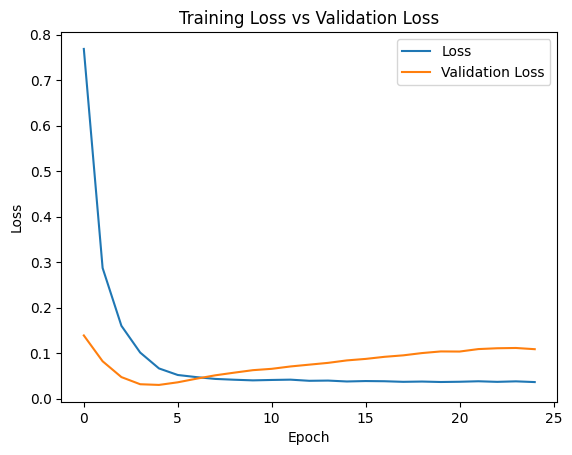

In [11]:
# Plot loss vs validation loss
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs Validation Loss')
plt.legend()
plt.show()

In [12]:
# Evaluate the model
loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)

# Make predictions
y_pred = model.predict(X_test)#.reshape(-1)
y_pred = y_pred[:, 0, 0]

# Compute evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(mse, r2)

3/3 [==============================] - 0s 4ms/step - loss: 0.1088
Test Loss: 0.10884688794612885
3/3 [==============================] - 1s 3ms/step
0.10832551864519203 -2.6515052954708898


In [13]:
#y_pred = y_pred[:, 0]
y_pred[:,0].shape, y_test.shape, y_pred[:,0]

((67,),
 (67,),
 array([0.7242771 , 0.7247559 , 0.72414654, 0.72393334, 0.722885  ,
        0.7231417 , 0.7241613 , 0.72376835, 0.7235137 , 0.72308165,
        0.72200966, 0.72206116, 0.7226685 , 0.7228627 , 0.7221997 ,
        0.72242534, 0.7229717 , 0.7230166 , 0.72267044, 0.7217841 ,
        0.7215473 , 0.72284687, 0.724983  , 0.7256253 , 0.72303027,
        0.7203573 , 0.7208497 , 0.72259235, 0.72517115, 0.72316694,
        0.71900403, 0.7158363 , 0.7155067 , 0.7150208 , 0.7188507 ,
        0.7244483 , 0.71976084, 0.71971804, 0.72170585, 0.7264953 ,
        0.7247386 , 0.72274464, 0.7204318 , 0.71584994, 0.71690726,
        0.71818435, 0.7201226 , 0.7186758 , 0.7186408 , 0.72220767,
        0.7245915 , 0.72574604, 0.7267965 , 0.7245902 , 0.72344434,
        0.7241983 , 0.7248812 , 0.72529024, 0.715983  , 0.7159012 ,
        0.7033237 , 0.7008448 , 0.69982177, 0.69937396, 0.6997931 ,
        0.70117676, 0.7045289 ], dtype=float32))

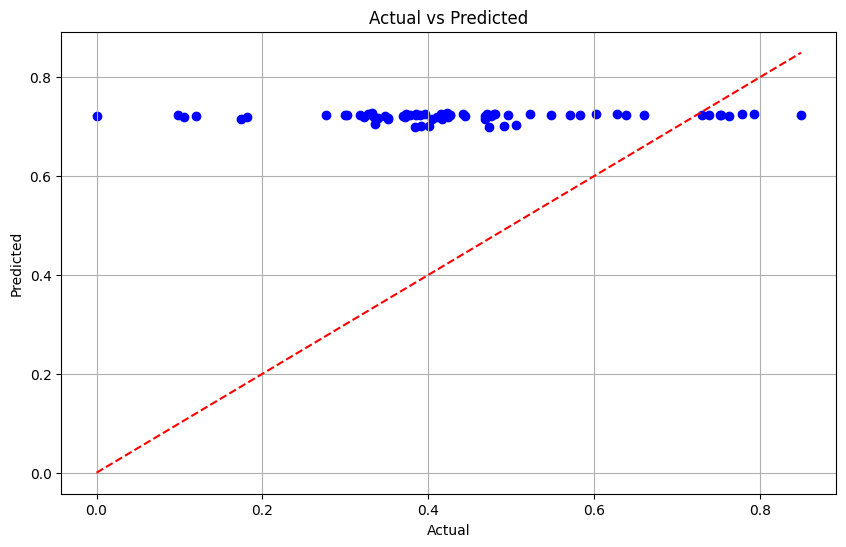

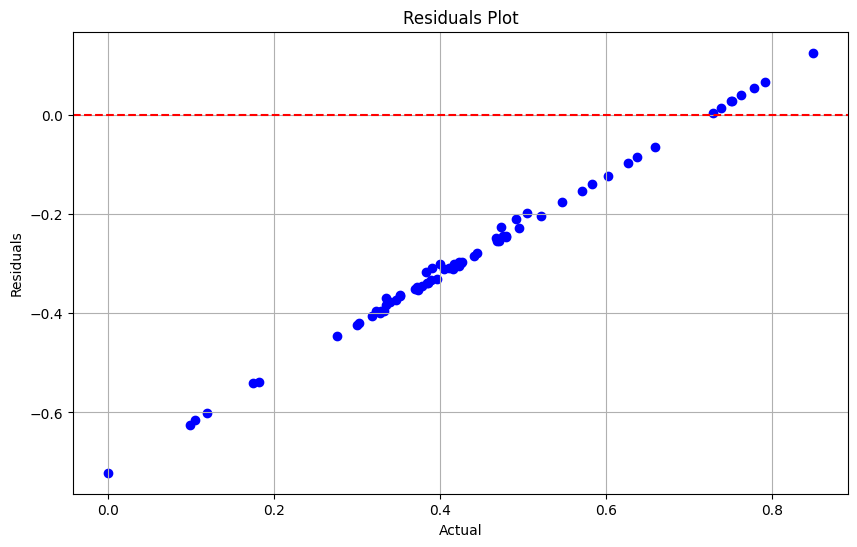

In [14]:
# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred[:,0], color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.grid(True)
plt.show()

# Plot residuals
residuals = y_test - y_pred[:,0]
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.grid(True)
plt.show()

In [15]:
# Save test data and predicted values to CSV
test_df = pd.DataFrame({'Actual_Index': y_test, 'Pred_Index': y_pred[:,0],
                        'Latitude': test_data['Lat'][-len(y_test):].values,
                        'Longitude': test_data['Lon'][-len(y_test):].values,
                        'Date': test_data['date'][-len(y_test):].dt.strftime('%Y-%m-%d')})  # Convert datetime to string
test_df.to_csv('test_pred_values.csv', index=False)

# Convert CSV to shapefile
geometry = [Point(xy) for xy in zip(test_df['Longitude'], test_df['Latitude'])]
gdf = gpd.GeoDataFrame(test_df, geometry=geometry)
gdf.crs = {'init': 'epsg:4326'}  # Assuming WGS84 coordinate reference system
gdf.to_file('test_predicted_values.shp')

C:\Users\janak\anaconda3\envs\python38\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\janak\AppData\Local\Temp\ipykernel_22320\877578966.py:12: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file('test_predicted_values.shp')


In [16]:
# Generate random data for prediction
random_data = pd.DataFrame({
    'date': pd.date_range(start='2020-11-01', end='2020-11-25'),
#    'latitude': np.random.uniform(low=data['Lat'].min(), high=(data['Lat'].max()), size=(61,)),
#    'longitude': np.random.uniform(low=(data['Lon'].min()), high=(data['Lon'].max()), size=(61,))
    'latitude': np.random.uniform(low=50, high=52, size=(25,)),
    'longitude': np.random.uniform(low=7, high=8, size=(25,))
})
random_data.to_csv(r'./outputs/random_data.csv', index=False)

In [23]:
n_features = 3
random_data = pd.read_csv(r'./outputs/random_data.csv')
# Normalize the random data
random_data['latitude'] = (random_data['latitude'] - random_data['latitude'].min()) / (random_data['latitude'].max() - random_data['latitude'].min())
random_data['longitude'] = (random_data['longitude'] - random_data['longitude'].min()) / (random_data['longitude'].max() - random_data['longitude'].min())
random_data['activity_index'] = np.nan  # Placeholder for activity index
random_data.to_csv(r'./outputs/random_data_normalized.csv', index=False)

# Prepare random data for prediction
X_random, _ = prepare_data(random_data, include_target=False)

print(type(X_random))
print(X_random)
X_random = X_random.reshape(-1, seq_length, 1, n_features, 1)



<class 'numpy.ndarray'>
[[[0.70497092 0.66061876        nan]
  [0.49996735 0.74658194        nan]
  [0.52906694 0.88924028        nan]
  [1.         0.89443334        nan]
  [0.47677134 0.14622408        nan]
  [0.31890866 0.12029941        nan]
  [0.23577992 0.                nan]]

 [[0.49996735 0.74658194        nan]
  [0.52906694 0.88924028        nan]
  [1.         0.89443334        nan]
  [0.47677134 0.14622408        nan]
  [0.31890866 0.12029941        nan]
  [0.23577992 0.                nan]
  [0.46696593 0.18590366        nan]]

 [[0.52906694 0.88924028        nan]
  [1.         0.89443334        nan]
  [0.47677134 0.14622408        nan]
  [0.31890866 0.12029941        nan]
  [0.23577992 0.                nan]
  [0.46696593 0.18590366        nan]
  [0.09313853 0.30107866        nan]]

 [[1.         0.89443334        nan]
  [0.47677134 0.14622408        nan]
  [0.31890866 0.12029941        nan]
  [0.23577992 0.                nan]
  [0.46696593 0.18590366        nan]
  [0.093

In [24]:
X_random

array([[[[[0.70497092],
          [0.66061876],
          [       nan]]],


        [[[0.49996735],
          [0.74658194],
          [       nan]]],


        [[[0.52906694],
          [0.88924028],
          [       nan]]],


        [[[1.        ],
          [0.89443334],
          [       nan]]],


        [[[0.47677134],
          [0.14622408],
          [       nan]]],


        [[[0.31890866],
          [0.12029941],
          [       nan]]],


        [[[0.23577992],
          [0.        ],
          [       nan]]]],



       [[[[0.49996735],
          [0.74658194],
          [       nan]]],


        [[[0.52906694],
          [0.88924028],
          [       nan]]],


        [[[1.        ],
          [0.89443334],
          [       nan]]],


        [[[0.47677134],
          [0.14622408],
          [       nan]]],


        [[[0.31890866],
          [0.12029941],
          [       nan]]],


        [[[0.23577992],
          [0.        ],
          [       nan]]],


        [[

In [25]:
X_df = pd.DataFrame(X_random.reshape(25,1))
X_df.to_csv(r'./outputs/X_random.csv', index=False)

ValueError: cannot reshape array of size 378 into shape (25,1)

In [26]:
# Make predictions on random data
y_random_pred = model.predict(X_random).reshape(-1)

1/1 [==============================] - 0s 19ms/step


In [33]:
y_random_pred = y_random_pred#[:,0]
(X_random.shape), len(y_random_pred)

((18, 7, 1, 3, 1), 54)

In [28]:


# Combine random data with predicted values
random_pred_df = pd.DataFrame({
    'Pred_Index': y_random_pred,
    'Latitude': random_data['latitude'].values[-len(y_random_pred):],
    'Longitude': random_data['longitude'].values[-len(y_random_pred):],
    'Date': random_data['date'].dt.strftime('%Y-%m-%d')[-len(y_random_pred):]
})

# Save random data and predicted values to CSV
random_pred_df.to_csv('random_pred_values.csv', index=False)

# Convert random data CSV to shapefile
geometry_random = [Point(xy) for xy in zip(random_pred_df['Longitude'], random_pred_df['Latitude'])]
gdf_random = gpd.GeoDataFrame(random_pred_df, geometry=geometry_random)
gdf_random.crs = {'init': 'epsg:4326'}  # Assuming WGS84 coordinate reference system
gdf_random.to_file('random_predicted_values.shp')


AttributeError: Can only use .dt accessor with datetimelike values

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization, MaxPooling2D
from shapely.geometry import Point
import geopandas as gpd
import os
import random

# Load the data from CSV file
data = pd.read_csv(r"./Daily_HAI_Mean.csv")

# Preprocess the data
data['date'] = pd.to_datetime(data['ds'])
data['latitude'] = (data['Lat'] - data['Lat'].min()) / (data['Lat'].max() - data['Lat'].min())
data['longitude'] = (data['Lon'] - data['Lon'].min()) / (data['Lon'].max() - data['Lon'].min())
data['activity_index'] = (data['y'] - data['y'].min()) / (data['y'].max() - data['y'].min())

# Split data into train and test sets (considering dates)
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Define parameters
seq_length = 7  # Length of sequence for each sample
n_features = 3  # Number of features (latitude, longitude, activity_index)
n_filters = 32  # Number of filters in ConvLSTM layers
kernel_size = (1, 1)  # Kernel size for ConvLSTM layers

# Prepare the data for ConvLSTM
def prepare_data(data):
    X = []
    y = []
    data = data.sort_values(by='date')  # Sort data by date
    for i in range(len(data) - seq_length):
        X.append(data[['latitude', 'longitude', 'activity_index']].iloc[i:i+seq_length].values)
        y.append(data['activity_index'].iloc[i+seq_length])
    X = np.array(X)
    y = np.array(y)
    return X, y

X_train, y_train = prepare_data(train_data)
X_test, y_test = prepare_data(test_data)

X_train, y_train = prepare_data(train_data)
X_test, y_test = prepare_data(test_data)

# Reshape the data for ConvLSTM
print("Before reshaping:")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train = X_train.reshape(-1, seq_length, 1, n_features, 1)
X_test = X_test.reshape(-1, seq_length, 1,  n_features, 1)

print("After reshaping:")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

# Build the ConvLSTM model
model = Sequential([
    ConvLSTM2D(filters=n_filters, kernel_size=kernel_size, activation='relu', input_shape=(seq_length, 1, n_features, 1), return_sequences=True),
    BatchNormalization(),
    #MaxPooling2D(pool_size=(2, 2)),
    
    ConvLSTM2D(filters=64, kernel_size=kernel_size, activation='relu', return_sequences=True),
    BatchNormalization(),
    #MaxPooling2D(pool_size=(2, 2)),
    
    ConvLSTM2D(filters=128, kernel_size=kernel_size, activation='relu', return_sequences=True),
    BatchNormalization(),
    #MaxPooling2D(pool_size=(2, 2)),
    
    ConvLSTM2D(filters=256, kernel_size=kernel_size, activation='relu', return_sequences=True),
    BatchNormalization(),
    #MaxPooling2D(pool_size=(2, 2)),
    
    ConvLSTM2D(filters=512, kernel_size=kernel_size, activation='relu'),
    BatchNormalization(),
    #MaxPooling2D(pool_size=(2, 2)),
    
    Dense(1)  # Output layer
])


# Compile the model
model.compile(optimizer=Adam(), loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)

# Make predictions
y_pred = model.predict(X_test).reshape(-1)

# Compute evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Plot loss vs validation loss
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs Validation Loss')
plt.legend()
plt.show()

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.grid(True)
plt.show()

# Plot residuals
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.grid(True)
plt.show()

# Print evaluation metrics
print("Mean Squared Error:", mse)
print("R-squared:", r2)

# Save test data and predicted values to CSV
test_df = pd.DataFrame({'Actual_Activity_Index': y_test, 'Predicted_Activity_Index': y_pred,
                        'Latitude': test_data['Lat'][-len(y_test):].values,
                        'Longitude': test_data['Lon'][-len(y_test):].values,
                        'Date': test_data['date'][-len(y_test):].values})
test_df.to_csv('test_predicted_values.csv', index=False)

# Convert CSV to shapefile
geometry = [Point(xy) for xy in zip(test_df['Longitude'], test_df['Latitude'])]
gdf = gpd.GeoDataFrame(test_df, geometry=geometry)
gdf.crs = {'init': 'epsg:4326'}  # Assuming WGS84 coordinate reference system
gdf.to_file('test_predicted_values.shp')

# Generate random data for prediction
random_data = pd.DataFrame({
    'Date': pd.date_range(start='2023-01-01', end='2023-01-10'),
    'Lat': np.random.uniform(low=data['Lat'].min(), high=data['Lat'].max(), size=(10,)),
    'Lon': np.random.uniform(low=data['Lon'].min(), high=data['Lon'].max(), size=(10,))
})

# Prepare random data for prediction
X_random, _ = prepare_data(random_data)
X_random = X_random.reshape(-1, seq_length, 1, n_features, 1)

# Make predictions on random data
y_random_pred = model.predict(X_random).reshape(-1)

# Combine random data with predicted values
random_pred_df = pd.DataFrame({'Predicted_Activity_Index': y_random_pred,
                               'Latitude': random_data['Lat'].values,
                               'Longitude': random_data['Lon'].values,
                               'Date': random_data['Date'].values})

# Save random data and predicted values to CSV
random_pred_df.to_csv('random_predicted_values.csv', index=False)

# Convert random data CSV to shapefile
geometry_random = [Point(xy) for xy in zip(random_pred_df['Longitude'], random_pred_df['Latitude'])]
gdf_random = gpd.GeoDataFrame(random_pred_df, geometry=geometry_random)
gdf_random.crs = {'init': 'epsg:4326'}  # Assuming WGS84 coordinate reference system
gdf_random.to_file('random_predicted_values.shp')
